# Sequence Data

In this tutorial, we'll take a detour away from stand-alone pieces of data such as still images, to data that is dependent on other data items in a sequence. For our example, we'll use text sentences. Language is naturally composed of sequence data, in the form of characters in words, and words in sentences. Other examples of sequence data include stock prices and  weather data over time. Videos, while containing still images, are also sequences. Elements in the data have a relationship with what comes before and what comes after, and this fact requires a different approach.

## Objectives

* Prepare sequence data to use in a [recurrent neural network](https://developers.google.com/machine-learning/glossary#recurrent-neural-network) (RNN)
* Build and train a model to perform word prediction

## Headline Generator

We've all seen text predictors in applications like the search bars, on cell phones, or in text editors that provide autocompletion of sentences. Many of the good text predictor models are trained on very large datasets, and take a lot of time and/or processing power to train. For this exercise, our predictor will be quite simple, but it will provide some simple exposure to language processing, sequence data, and one of the classic architecture elements used to train sequences, *recurrent neural networks* or *RNNs*.

## Reading in the Data

Our dataset consists of headlines from the [New York Times](https://www.nytimes.com/) newspaper over the course of several months. We'll start by reading in all the headlines from the articles. The articles are in CSV files, so we can use *pandas* to read them in.

In [ ]:
import os 
import pandas as pd

nyt_dir = 'data/nyt_dataset/articles/'

all_headlines = []
for filename in os.listdir(nyt_dir):
    if 'Articles' in filename:
        # Read in all the data from the CSV file
        headlines_df = pd.read_csv(nyt_dir + filename)
        # Add all of the headlines to our list
        all_headlines.extend(list(headlines_df.headline.values))
len(all_headlines)

9335

Let's take a look at our first few headlines:

In [ ]:
all_headlines[:20]

['My Beijing: The Sacred City',
 '6 Million Riders a Day, 1930s Technology',
 'Seeking a Cross-Border Conference',
 'Questions for: ‘Despite the “Yuck Factor,” Leeches Are Big in Russian Medicine’',
 'Who Is a ‘Criminal’?',
 'An Antidote to Europe’s Populism',
 'The Cost of a Speech',
 'Degradation of the Language',
 'On the Power of Being Awful',
 'Trump Garbles Pitch on a Revised Health Bill',
 'What’s Going On in This Picture? | May 1, 2017',
 'Unknown',
 'When Patients Hit a Medical Wall',
 'Unknown',
 'For Pregnant Women, Getting Serious About Whooping Cough',
 'Unknown',
 'New York City Transit Reporter in Wonderland: Riding the London Tube',
 'How to Cut an Avocado Without Cutting Yourself',
 'In Fictional Suicide, Health Experts Say They See a Real Cause for Alarm',
 'Claims of Liberal Media Bias Hit ESPN, Too']

## Cleaning the Data

An important part of natural language processing (NLP) tasks (where computers deal with language), is processing text in a way that computers can understand it. We're going to take each of the words that appears in our dataset and represent it with a number. This will be part of a process called *tokenization*. 

Before we do that, we need to make sure we have good data. There are some headlines that are listed as "Unknown".  We don't want these items in our training set, so we'll filter them out: 

In [ ]:
# Remove all headlines with the value of "Unknown"
all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

8603

Let's take another look:

In [ ]:
all_headlines[:20]

['My Beijing: The Sacred City',
 '6 Million Riders a Day, 1930s Technology',
 'Seeking a Cross-Border Conference',
 'Questions for: ‘Despite the “Yuck Factor,” Leeches Are Big in Russian Medicine’',
 'Who Is a ‘Criminal’?',
 'An Antidote to Europe’s Populism',
 'The Cost of a Speech',
 'Degradation of the Language',
 'On the Power of Being Awful',
 'Trump Garbles Pitch on a Revised Health Bill',
 'What’s Going On in This Picture? | May 1, 2017',
 'When Patients Hit a Medical Wall',
 'For Pregnant Women, Getting Serious About Whooping Cough',
 'New York City Transit Reporter in Wonderland: Riding the London Tube',
 'How to Cut an Avocado Without Cutting Yourself',
 'In Fictional Suicide, Health Experts Say They See a Real Cause for Alarm',
 'Claims of Liberal Media Bias Hit ESPN, Too',
 'Is the dream in Australia crumbling?',
 'Police in Texas Change Account in Officer’s Fatal Shooting of 15-Year-Old',
 'Most Adults Favor Sex Ed. Most Students Don’t Get It.']

We also want to remove punctuation and make our sentences all lower case, because this will make our model easier to train.  For our purposes, there is little or no difference between a line ending with "!" or "?" or whether words are capitalized, as in "The" or lower-case, as in "the".  With fewer unique tokens, our model will be easier to train. 

We could filter our sentences prior to tokenization, but we don't need to because this can all be done using the Keras `Tokenizer`.

## Tokenization

Right now, our dataset consists of a set of headlines, each made up of a series of words. We want to give our model a way of representing those words in a way that it can understand. With tokenization, we separate a piece of text into smaller chunks (tokens), which in this case are words. Each unique word is then assigned a number, as this is a way that our model can understand the data. Keras has a class that will help us tokenize our data:

```python
tf.keras.preprocessing.text.Tokenizer(
    num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
    split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
)
```

Taking a look at the [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class in Keras, we see the default values are already set up for our use case.  The `filters` string already removes punctuation and the `lower` flag sets words to lower case.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the words in our headlines
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_headlines)
total_words = len(tokenizer.word_index) + 1
print('Total words: ', total_words)

Total words:  11753


We can take a quick look at the `word_index` dictionary to see how the tokenizer saves the words:

In [ ]:
# Print a subset of the word_index dictionary created by Tokenizer
subset_dict = {key: value for key, value in tokenizer.word_index.items() \
               if key in ['a','man','a','plan','a','canal','panama']}
print(subset_dict)

{'a': 2, 'plan': 82, 'man': 139, 'panama': 2732, 'canal': 7047}


We can use the `texts_to_sequences` method to see how the tokenizer saves the words:

In [ ]:
tokenizer.texts_to_sequences(['a','man','a','plan','a','canal','panama'])

[[2], [139], [2], [82], [2], [7047], [2732]]

## Creating Sequences

Now that we've tokenized the data, turning each word into a representative number, we will create sequences of tokens from the headlines. These sequences are what we will train our deep learning model on. 

For example, let's take the headline, "nvidia launches ray tracing gpus". Each word is going to be replaced by a corresponding number, for instance: nvidia - 5, launches - 22, ray - 94, tracing - 16, gpus - 102. The full sequence would be: [5, 22, 94, 16, 102]. However, it is also valuable to train on the smaller sequences within the headline, such as "nvidia launches". We'll take each headline and create a set of sequences to fill our dataset. Next, let's use our tokenizer to convert our headlines to a set of sequences.

In [ ]:
# Convert data to sequence of tokens 
input_sequences = []
for line in all_headlines:
    # Convert our headline into a sequence of tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # Create a series of sequences for each headline
    for i in range(1, len(token_list)):
        partial_sequence = token_list[:i+1]
        input_sequences.append(partial_sequence)

print(tokenizer.sequences_to_texts(input_sequences[:5]))
input_sequences[:5]

['my beijing', 'my beijing the', 'my beijing the sacred', 'my beijing the sacred city', '6 million']


[[52, 1616],
 [52, 1616, 1],
 [52, 1616, 1, 1992],
 [52, 1616, 1, 1992, 125],
 [126, 346]]

## Padding Sequences

Right now our sequences are of various lengths. For our model to be able to train on the data, we need to make all the sequences the same length. To do this we'll add padding to the sequences. Keras has a built-in `pad_sequences` [method](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) that we can use. 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Determine max sequence length
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences with zeros at the beginning to make them all max length
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   52, 1616], dtype=int32)

## Creating Predictors and Target

We also want to split up our sequences into predictors and a target. The last word of the sequence will be our target, and the first words of the sequence will be our predictors. As an example, take a look at the full headline: "nvidia releases ampere graphics cards"

<table>
<tr><td>PREDICTORS </td> <td>           TARGET </td></tr>
<tr><td>nvidia                   </td> <td>  releases </td></tr>
<tr><td>nvidia releases               </td> <td>  ampere </td></tr>
<tr><td>nvidia releases ampere      </td> <td>  graphics</td></tr>
<tr><td>nvidia releases ampere graphics </td> <td>  cards</td></tr>
</table>

In [ ]:
# Predictors are every word except the last
predictors = input_sequences[:,:-1]
# Labels are the last word
labels = input_sequences[:,-1]
labels[:5]

array([1616,    1, 1992,  125,  346], dtype=int32)

Like our earlier sections, these targets are categorical. We are predicting one word out of our possible total vocabulary. Instead of the network predicting scalar numbers, we will have it predict binary categories. 

In [ ]:
from tensorflow.keras import utils

labels = utils.to_categorical(labels, num_classes=total_words)

## Creating the Model

For our model, we're going to use a couple of new layers to deal with our sequential data. 

### [Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

Our first layer is an embedding layer:

```Python
model.add(Embedding(input_dimension, output_dimension, input_length=input_len))
```

This layer will take the tokenized sequences and will learn an embedding for all of the words in the training dataset. Mathematically, embeddings work the same way as a neuron in a neural network, but conceptually, their goal is to reduce the number of dimensions for some or all of the features. In this case, it will represent each word as a vector, and the information within that vector will contain the relationships between each word.

Learn more about embedding layers [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/).

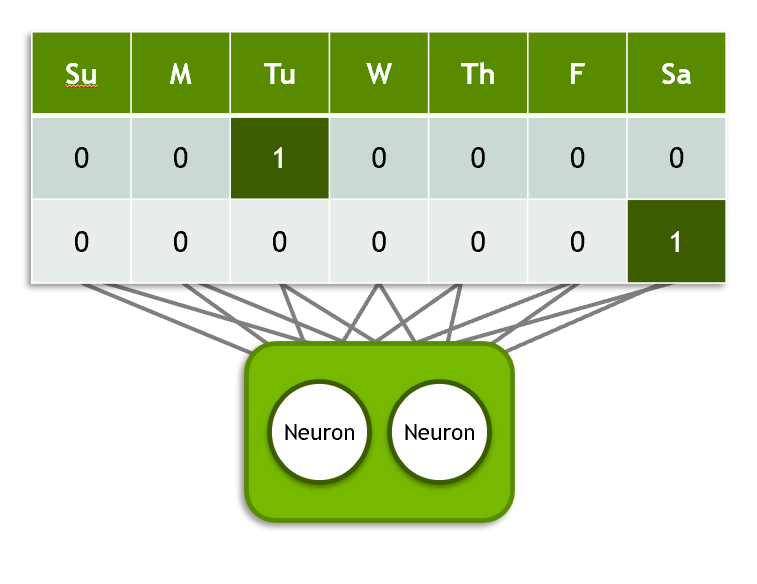

### [Long Short Term Memory Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

Our next, and very important layer, is a long short term memory layer (LSTM). An LSTM is a type of recurrent neural network or RNN. Unlike traditional feed-forward networks that we've seen so far, recurrent networks have loops in them, allowing information to persist. Here's a representation of a recurrent network:

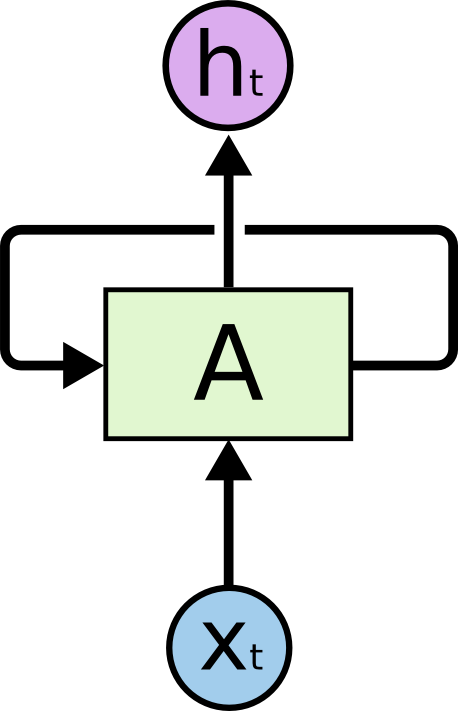

New information (x) gets passed in to the network, which spits out a prediction (h). Additionally, information from that layer gets saved, and used as input for the next prediction. This may seem a bit complicated, but let's look at it unrolled: 

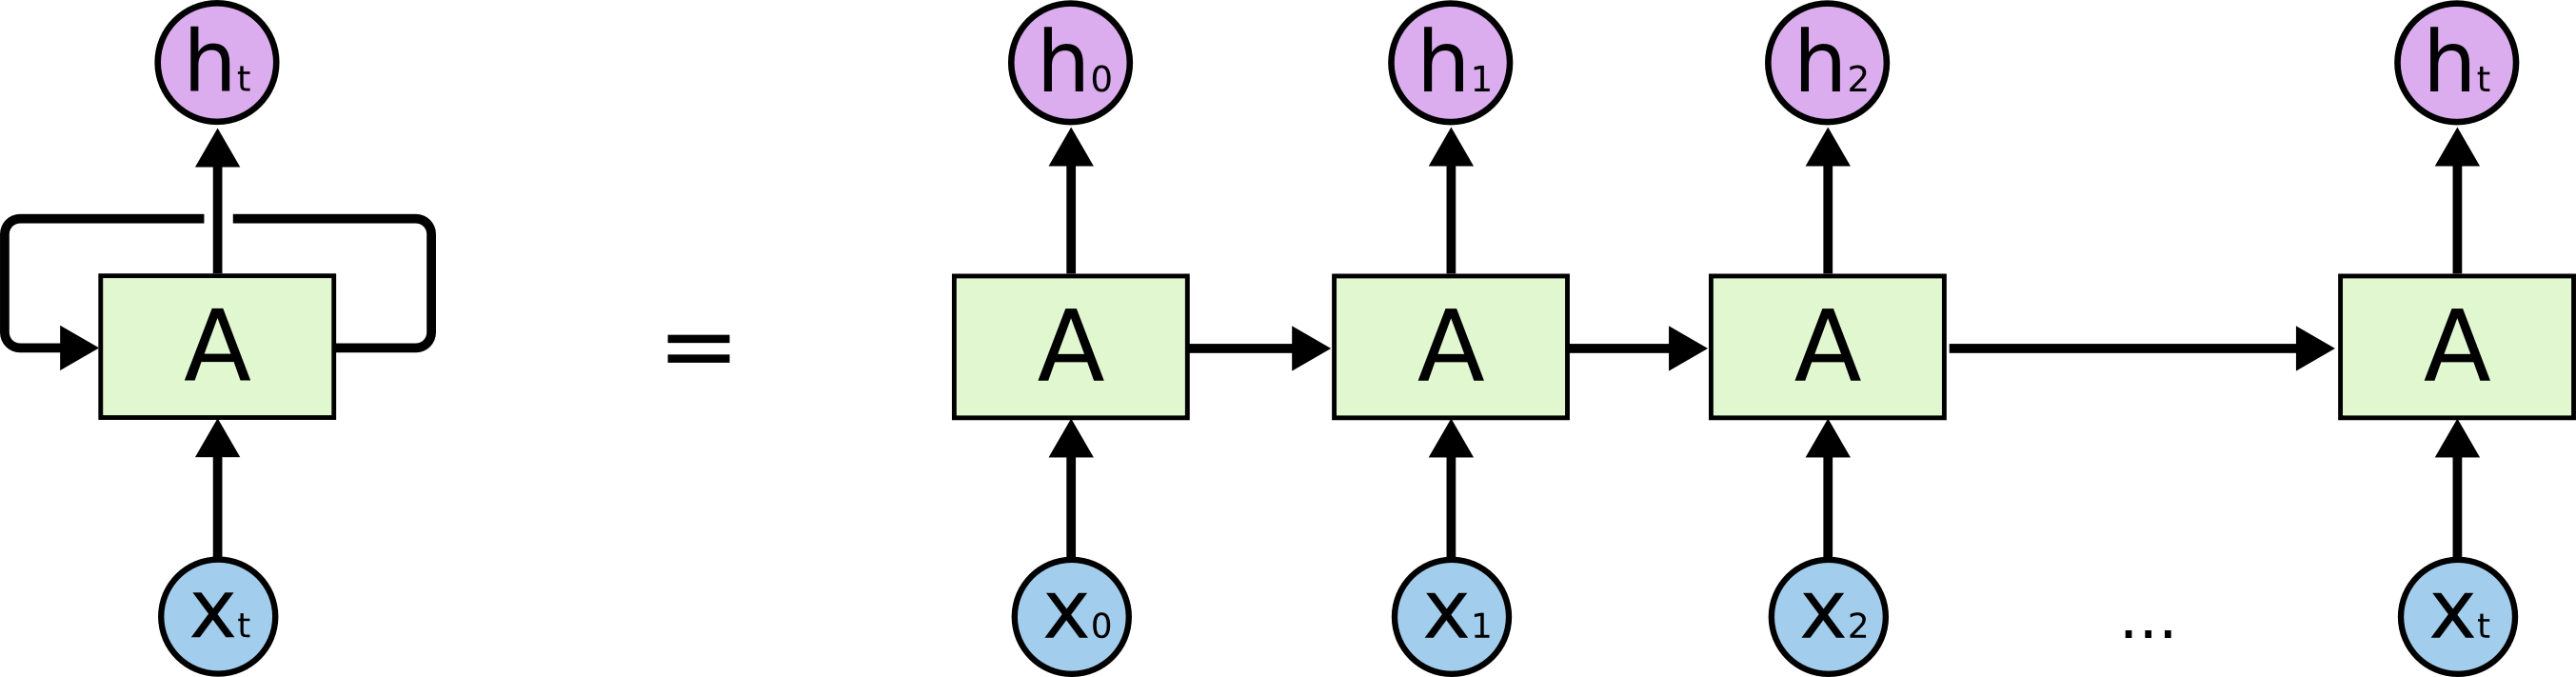

We can see that when a new piece of data (x) is fed into the network, that network both spits out a prediction (h) and also passes some information along to the next layer. That next layer gets another piece of data, but gets to learn from the layer before it as well.

Traditional RNNs suffer from the issue of more recent information contributing more than information from further back. LSTMs are a special type of recurrent layer that are able to learn and retain longer term information. If you'd like to read more about RNNs and LSTMs, we recommend [this article](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). 

Alright, let's create our model:

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

# Input is max sequence length - 1, as we've removed the last word for the label
input_len = max_sequence_len - 1 

model = Sequential()

# Add input embedding layer
model.add(Embedding(total_words, 10, input_length=input_len))

# Add LSTM layer with 100 units
model.add(LSTM(100))
model.add(Dropout(0.1))

# Add output layer
model.add(Dense(total_words, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 10)            117530    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 11753)             1187053   
Total params: 1,348,983
Trainable params: 1,348,983
Non-trainable params: 0
_________________________________________________________________


## Compiling the Model

As before, we compile our model with categorical crossentropy, as we're categorically predicting one word from our total vocabulary. In this case, we are not going to use accuracy as a metric, because text prediction is not measured as being more or less accurate in the same way as image classification.

We are also going to select a particular optimizer that is well suited for LSTM tasks, called the *Adam* optimizer. Details of optimizers are a bit out of scope for this course, but what's important to know is that different optimizers can be better for different deep learning tasks. You can read more about them, including the Adam optimizer [here](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3). 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Training the Model

Similar to earlier sections, we fit our model in the same way. This time we'll train for 30 epochs, which will take a few minutes. You'll notice that we don't have a training or validation accuracy score in this case. This reflects our different problem of text prediction.

In [ ]:
model.fit(predictors, labels, epochs=30, verbose=1)

Epoch 1/30
1666/1666 [==============================] - 8s 5ms/step - loss: 7.8909
Epoch 2/30
1666/1666 [==============================] - 8s 5ms/step - loss: 7.4867
Epoch 3/30
1666/1666 [==============================] - 8s 5ms/step - loss: 7.3035
Epoch 4/30
1666/1666 [==============================] - 8s 5ms/step - loss: 7.0723
Epoch 5/30
1666/1666 [==============================] - 8s 5ms/step - loss: 6.8376
Epoch 6/30
1666/1666 [==============================] - 8s 5ms/step - loss: 6.5901
Epoch 7/30
1666/1666 [==============================] - 8s 5ms/step - loss: 6.3348
Epoch 8/30
1666/1666 [==============================] - 8s 5ms/step - loss: 6.0862
Epoch 9/30
1666/1666 [==============================] - 8s 5ms/step - loss: 5.8423
Epoch 10/30
1666/1666 [==============================] - 8s 5ms/step - loss: 5.6065
Epoch 11/30
1666/1666 [==============================] - 8s 5ms/step - loss: 5.3849
Epoch 12/30
1666/1666 [==============================] - 8s 5ms/step - loss: 5.1798
E

## Discussion of Results

We can see that the loss decreased over the course of training. We could train our model further to decrease the loss, but that would take some time, and we're not looking for a perfect text predictor right now. Next let's try using the model to make predictions. 

## Making Predictions

In order to make predictions, we'll need to start with a seed text, and prepare it in the same way we prepared our dataset. This will mean tokenizing and padding. Once we do this, we can pass it into our model to make a prediction. We'll create a function to do this called `predict_next_token`:

In [ ]:
def predict_next_token(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    prediction = model.predict_classes(token_list, verbose=0)
    return prediction

In [ ]:
prediction = predict_next_token("today in new york")
prediction

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([73])

Let's use our tokenizer to decode the predicted word:

In [ ]:
tokenizer.sequences_to_texts([prediction])

['today']

## Generate New Headlines

Now that we're able to predict new words, let's create a function that can predict headlines of more than just one word. The function below creates a new headline of arbitrary length.

In [ ]:
def generate_headline(seed_text, next_words=1):
    for _ in range(next_words):
        # Predict next token
        prediction = predict_next_token(seed_text)
        # Convert token to word
        next_word = tokenizer.sequences_to_texts([prediction])[0]
        # Add next word to the headline. This headline will be used in the next pass of the loop.
        seed_text += " " + next_word
    # Return headline as title-case
    return seed_text.title()

Now try some headlines!

In [ ]:
seed_texts = [
    'washington dc is',
    'today in new york',
    'the school district has',
    'crime has become']
for seed in seed_texts:
    print(generate_headline(seed, next_words=5))

Washington Dc Is Tech A Lifesaver Not His
Today In New York Today A First High Both
The School District Has The Sheep Quite Do The
Crime Has Become The Potato In A Power


The results may be a bit underwhelming after 30 epochs of training.  We can notice that most of the headlines make some kind of grammatical sense, but don't necessarily indicate a good contextual understanding.  The results might improve somewhat by running more epochs. You can do this by runnning the training `fit` cell again (and again!) to train another 30 epochs each time.  You should see the loss value go down.  Then try the tests again.  Results can vary quite a bit!

Other improvements would be to try using pretrained embeddings with Word2Vec or GloVe, rather than learning them during training as we did with the Keras Embedding layer.  Some information on how to do that can be found [here](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

Ultimately, however, NLP has moved beyond simple LSTM models to Transformer-based pre-trained models, which are able to learn language context from huge amounts of textual data such as Wikipedia.  These pre-trained models are then used as a starting point for transfer learning to solve NLP tasks such as the one we just tried for text completion.  You can try one of these models yourself by checking out this [state-of-the-art text predictor here](https://transformer.huggingface.co/doc/gpt2-large) based on a [GPT-2 model](https://openai.com/blog/better-language-models/).

To learn more about Transformer-based models, check out [this blog](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) on Bidirectional Encoder Representations from Transformers (BERT) and look for information on additional coursework in the "Next Steps" page for this DLI course.

## Summary

Great work! You've successfully trained a model to predict words in a headline, and used that model to create headlines of various lengths. Feel free to experiment and generate some more headlines.

### Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}